In [28]:
import os
from pathlib import Path
from pprint import pformat,pprint


import requests
import yfinance as yf
from dotenv import load_dotenv
from langchain.messages import RemoveMessage
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool,Tool
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from pydantic import BaseModel,Field
from langgraph.types import interrupt


In [29]:
class LookupStockInput(BaseModel):
    company_name: str = Field(
        description="The full company name, e.g. Tesla Inc."
    )

class FetchStockInput(BaseModel):
    stock_symbol: str = Field(
        description="Stock ticker symbol, e.g. TSLA"
    )


In [30]:
@tool(args_schema=LookupStockInput)
def lookup_stock_symbol(company_name: str) -> str:
    """
    Converts a company name to its stock symbol using a financial API.

    Parameters:
        company_name (str): The full company name (e.g., 'Tesla').

    Returns:
        str: The stock symbol (e.g., 'TSLA') or an error message.
    """
    api_url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": "4CB8FGQ3W6VL4X49",
    }
    response = requests.get(api_url, params=params)
    data = response.json()
    # print(f"Stock data : {data}")

    if "bestMatches" in data and data["bestMatches"]:
        symbol = data["bestMatches"][0]["1. symbol"]
        print(f"symbol : {symbol}")
        return data["bestMatches"][0]["1. symbol"]
    else:
        return f"Symbol not found for {company_name}."

@tool(args_schema=FetchStockInput)
def fetch_stock_data_raw(stock_symbol: str) -> dict:
    """
    Fetches comprehensive stock data for a given symbol and returns it as a combined dictionary.

    Parameters:
        stock_symbol (str): The stock ticker symbol (e.g., 'TSLA').
        period (str): The period to analyze (e.g., '1mo', '3mo', '1y').

    Returns:
        dict: A dictionary combining general stock info and historical market data.
    """
    period = "1mo"
    try:
        stock = yf.Ticker(stock_symbol)

        # Retrieve general stock info and historical market data
        info = stock.info
        # Historical OHLCV data
        # stock_history = stock.history(period=period).to_dict()

        # Combine both into a single dictionary
        summary = {
            "symbol": stock_symbol,
            "current_price": info.get("currentPrice"),
            "market_cap": info.get("marketCap"),
            "pe_ratio": info.get("trailingPE"),
            "eps": info.get("trailingEps"),
            "52w_high": info.get("fiftyTwoWeekHigh"),
            "52w_low": info.get("fiftyTwoWeekLow"),
            "sector": info.get("sector"),
            "industry": info.get("industry"),
        }

        return pformat(summary)
    except Exception as e:
        return {"error": f"Error fetching stock data for {stock_symbol}: {str(e)}"}


In [31]:
# System message for financial related queries
Finance_system_message = SystemMessage(
    content=(
        """
            You are a professional financial assistant specializing in stock market analysis and investment strategies. 
            Your role is to analyze stock data and provide **clear, decisive recommendations** that users can act on, 
            whether they already hold the stock or are considering investing.

            You have access to a set of tools that can provide the data you need to analyze stocks effectively. 
            Use these tools to gather relevant information such as stock symbols, current prices, historical trends, 
            and key financial indicators. Your goal is to leverage these resources efficiently to generate accurate, 
            actionable insights for the user.

            Your responses should be:
            - **Concise and direct**, summarizing only the most critical insights.
            - **Actionable**, offering clear guidance on whether to buy, sell, hold, or wait for better opportunities.
            - **Context-aware**, considering both current holders and potential investors.
            - **Free of speculation**, relying solely on factual data and trends.

            ### Response Format:
            1. **Recommendation:** Buy, Sell, Hold, or Wait.
            2. **Key Insights:** Highlight critical trends and market factors that influence the decision.
            3. **Suggested Next Steps:** What the user should do based on their current position.
            If the user does not specify whether they own the stock, provide recommendations for both potential buyers and current holders. Ensure your advice considers valuation, trends, and market sentiment.

            Your goal is to help users make informed financial decisions quickly and confidently.
        """
    )
)


In [32]:
PROJECT_ROOT = Path.cwd().parent
load_dotenv(PROJECT_ROOT / ".env")

GROQ_API_KEY = os.getenv("GROQ_API_KEY_DEFAULT")


In [33]:
# Initialize Groq LLM
llm = ChatGroq(
    api_key=GROQ_API_KEY, 
    model_name="llama-3.1-8b-instant", 
    temperature=0.2,
    max_tokens=1024
)


In [34]:
# Create tool bindings with additional attributes and attach the tools to the llm:
toolbox = [lookup_stock_symbol, fetch_stock_data_raw]

llm_with_tools = llm.bind_tools(
    toolbox,
    tool_choice="auto",
)


In [35]:
# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([Finance_system_message] + state["messages"])]}


In [36]:
# Node
def intent_check(state: MessagesState):
    user_request = state["messages"][-1].content

    financial_check_prompt = f"""
        You are an intent classifier. Your task is to determine if the user's request is specifically related to finance, investments, or financial advice.

        Evaluate the following user request:

        "{user_request}"

        If the request is about finance, investments, or financial advice, respond with "True".
        If it is unrelated to finance, respond with "False".

        Respond with only "True" or "False" and nothing else.
    """

    llm_response = llm.invoke([HumanMessage(content=financial_check_prompt)]).content.strip().lower()
    print(f"LLM Response for intent checking : {llm_response}")
    is_financial_question = llm_response == 'true'

    if not is_financial_question:
        interrupt(
            "This assistant only handles finance and investment-related questions. "
            "Please rephrase your question accordingly."
        )

    return state


In [37]:
# Defining Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("intent_check", intent_check)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "intent_check")
builder.add_edge("intent_check", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")


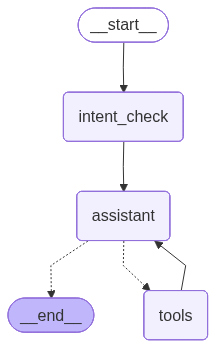

In [38]:
memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)
graph


In [39]:
# start a new conversation
thread = {"configurable": {"thread_id": "1"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="What is the weather outside?")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

What is the weather outside?
LLM Response for intent checking : false
================================ Human Message =================================

What is the weather outside?


In [40]:
state = graph.get_state(thread)
pprint(state)


StateSnapshot(values={'messages': [HumanMessage(content='What is the weather outside?', additional_kwargs={}, response_metadata={}, id='30ac6eb8-532d-45d3-ba24-20614ceea841')]}, next=('intent_check',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6c6e-3e9b-6e24-8000-9b0ed65d8f25'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-21T12:44:13.618930+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6c6e-3e99-6f7e-bfff-77cefd733b63'}}, tasks=(PregelTask(id='ff3c7107-3f8d-33d9-e46f-1598bdd1975e', name='intent_check', path=('__pregel_pull', 'intent_check'), error=None, interrupts=(Interrupt(value='This assistant only handles finance and investment-related questions. Please rephrase your question accordingly.', id='844c8f6ed6e6bd351eef1c24ed6a3050'),), state=None, result=None),), interrupts=(Interrupt(value='This assistant only handles finance and investment-related questio

In [41]:
print(state.next)


('intent_check',)


In [42]:
# start a new conversation
thread = {"configurable": {"thread_id": "2"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="What is a stock symbol for Tesla?")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

What is a stock symbol for Tesla?
LLM Response for intent checking : true
================================ Human Message =================================

What is a stock symbol for Tesla?
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (hyjz1x99e)
 Call ID: hyjz1x99e
  Args:
    company_name: Tesla
symbol : 0R0X.LON
================================= Tool Message =================================
Name: lookup_stock_symbol

0R0X.LON
================================== Ai Message ==================================

It seems like the function call returned a stock symbol for a London exchange, but the function 'lookup_stock_symbol' is supposed to return a stock symbol for a financial API. Let me try again.
Tool Calls:
  lookup_stock_symbol (9b6bnbtv9)
 Call ID: 9b6bnbtv9
  Args:
    company_name: Tesla Inc.
================================= T

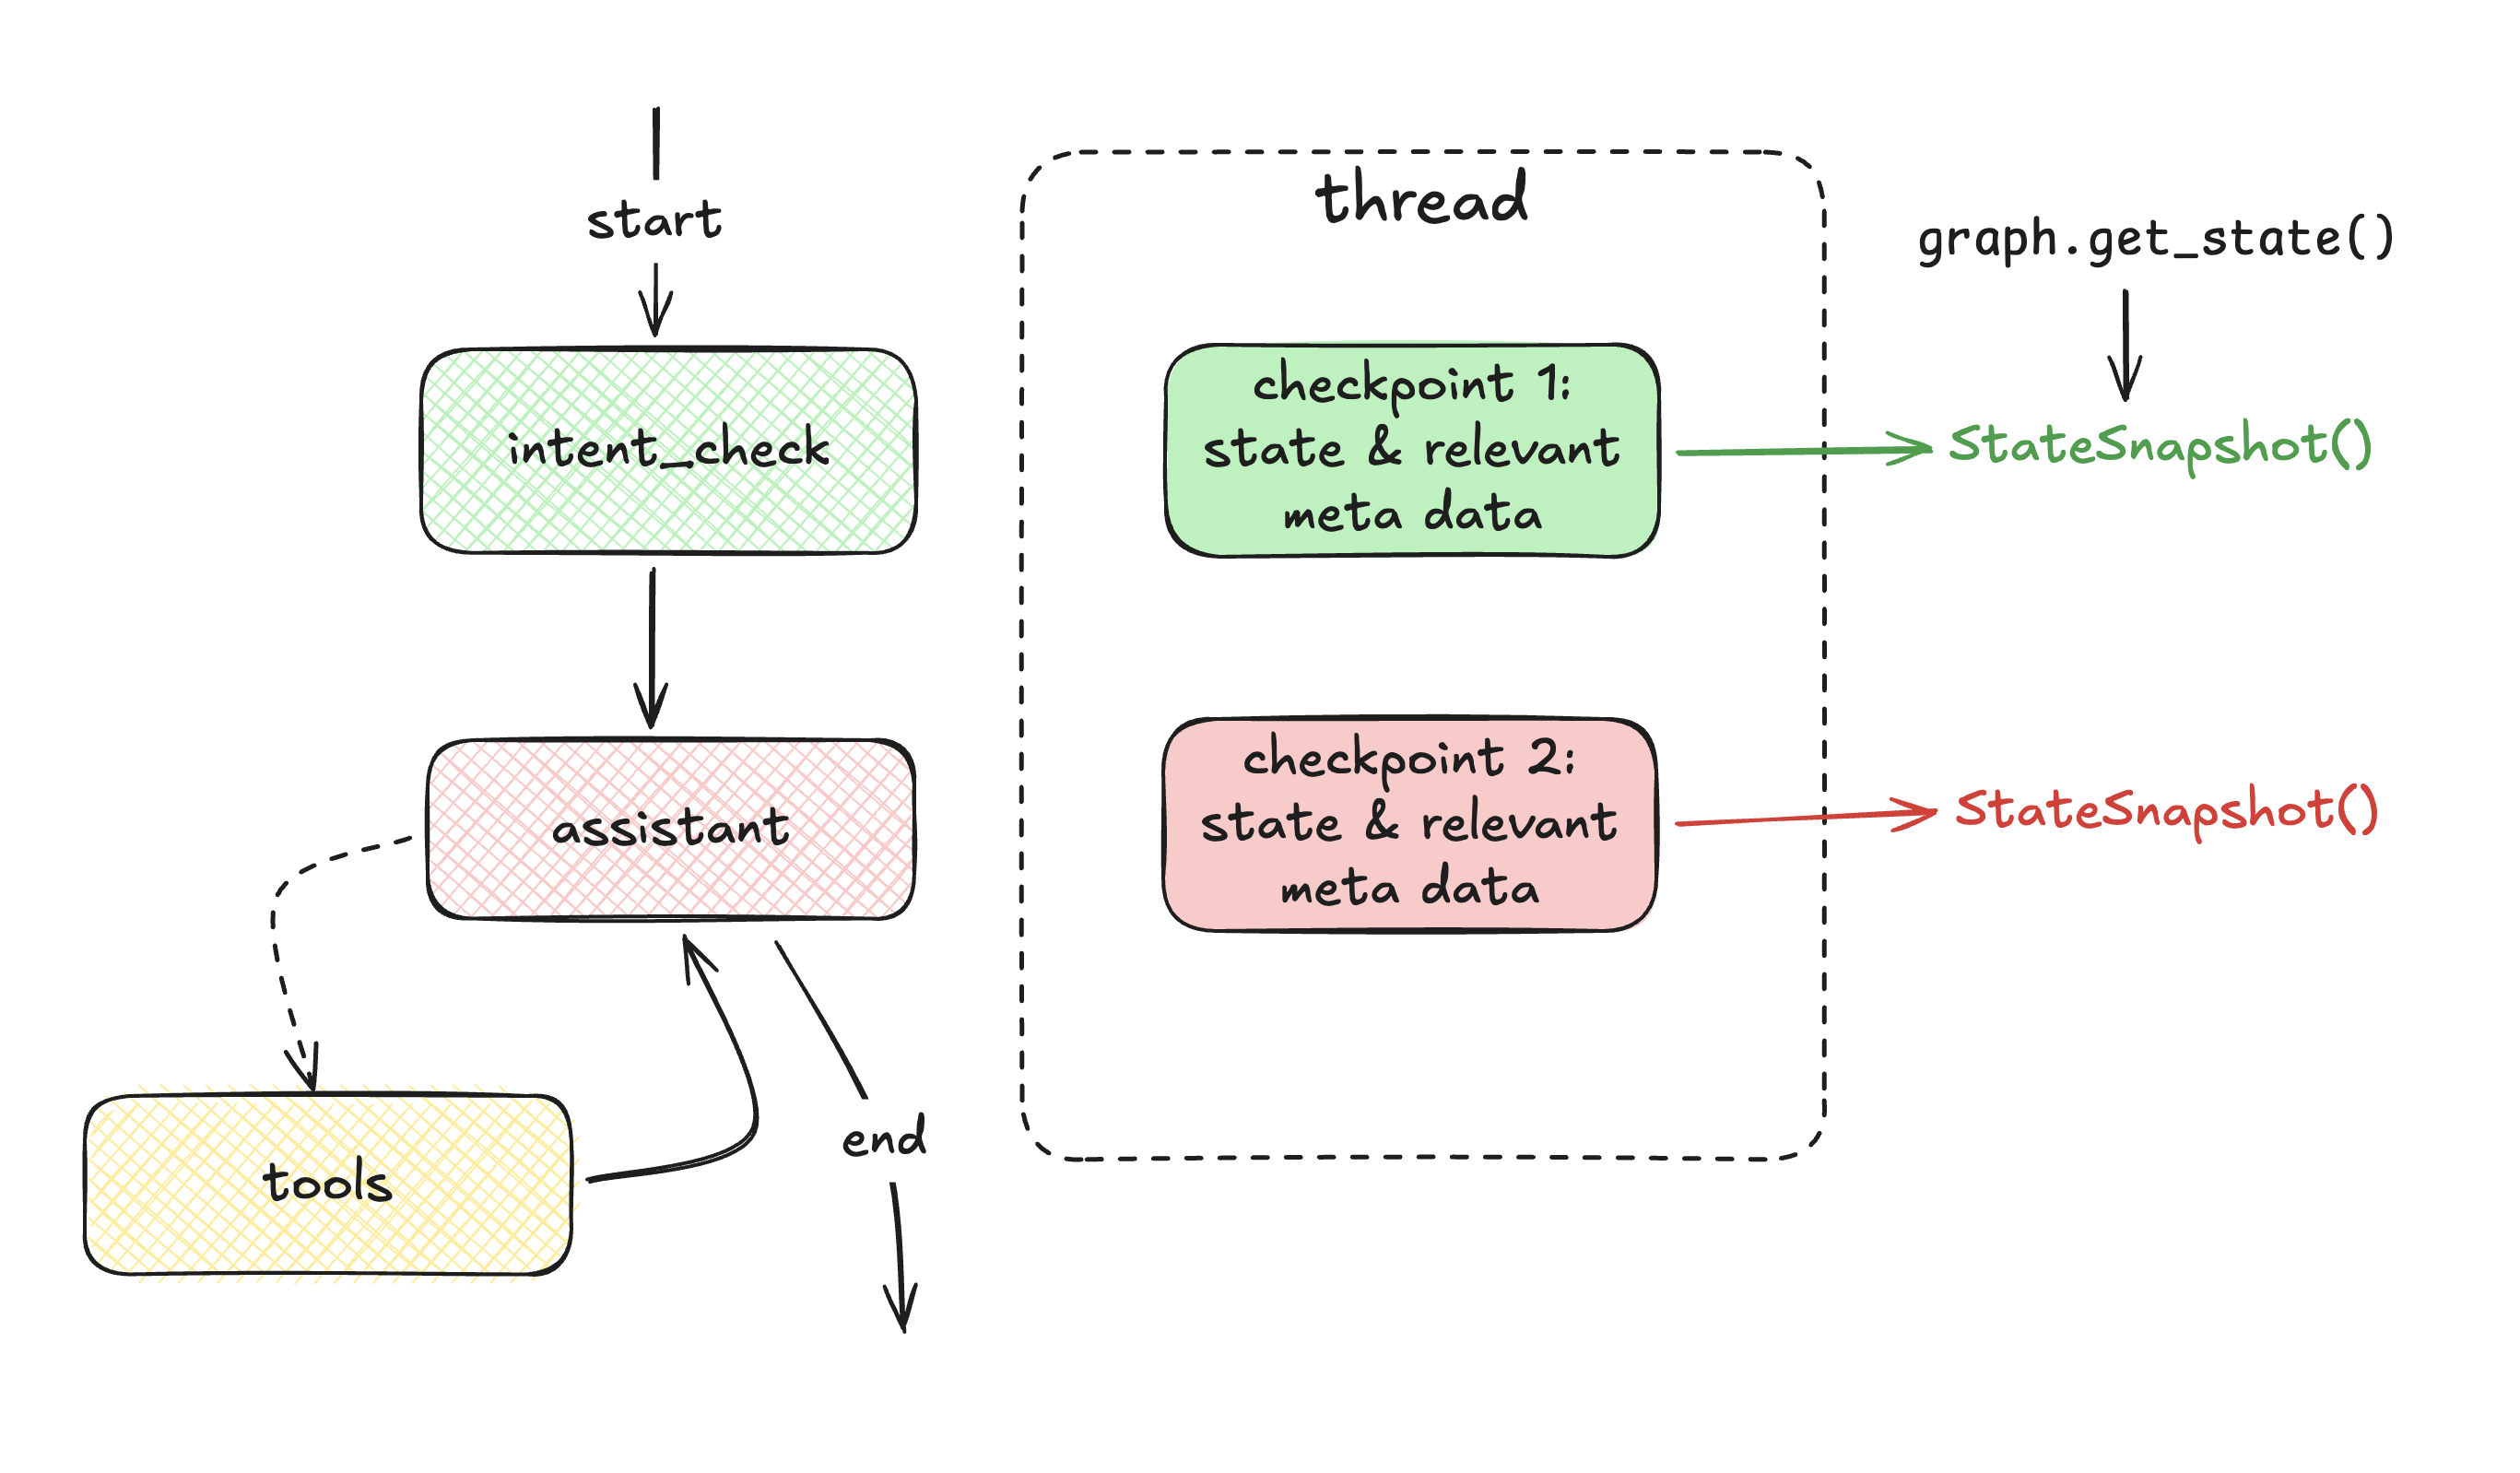

In [43]:
state = graph.get_state(thread)
print(state.next)
print(state)


()
StateSnapshot(values={'messages': [HumanMessage(content='What is a stock symbol for Tesla?', additional_kwargs={}, response_metadata={}, id='775a2a2e-5930-41b1-98eb-bcc559b569a8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hyjz1x99e', 'function': {'arguments': '{"company_name":"Tesla"}', 'name': 'lookup_stock_symbol'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 872, 'total_tokens': 889, 'completion_time': 0.025210887, 'completion_tokens_details': None, 'prompt_time': 0.122457322, 'prompt_tokens_details': None, 'queue_time': 0.063132068, 'total_time': 0.147668209}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019be095-862d-7ee0-89c0-a3ad8cc0ff48-0', tool_calls=[{'name': 'lookup_stock_symbol', 'args': {'company_name': 'Tesla'}, 'id': 'hyjz1x99e', 'type': 'tool_

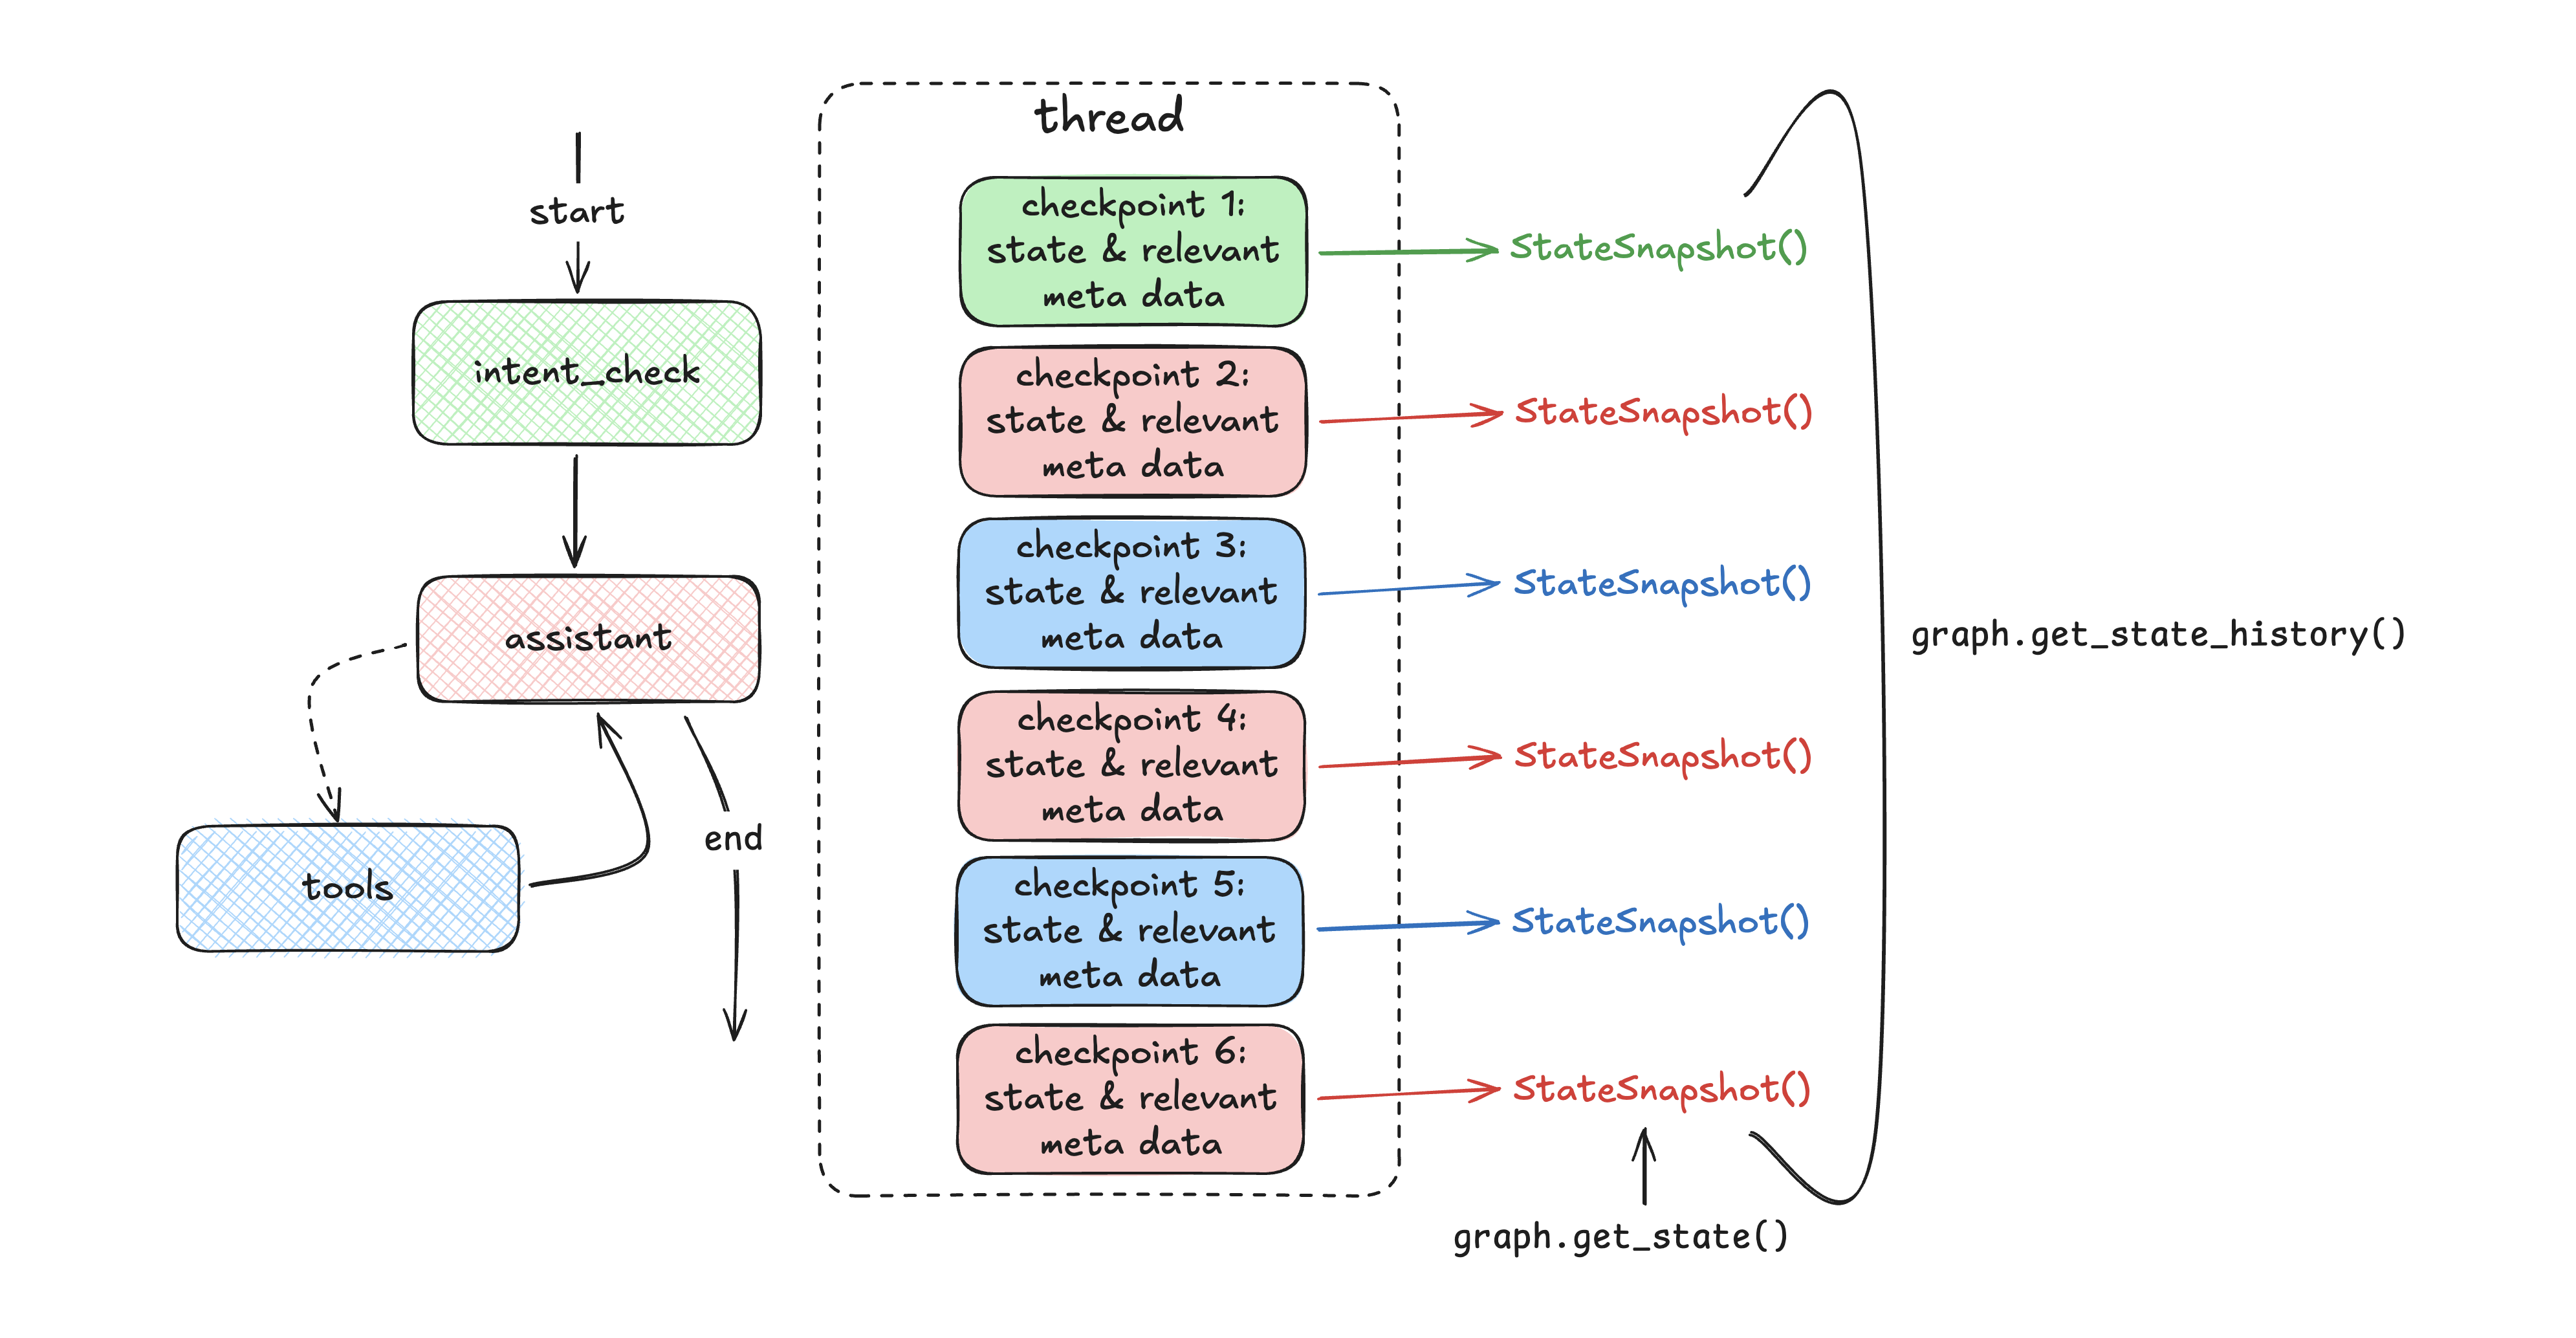

In [44]:
# get_state - most recent snapshot
# get_state_history - all the snapshots of the state

all_states = [s for s in graph.get_state_history(thread)]
len(all_states)


10

In [45]:
all_states


[StateSnapshot(values={'messages': [HumanMessage(content='What is a stock symbol for Tesla?', additional_kwargs={}, response_metadata={}, id='775a2a2e-5930-41b1-98eb-bcc559b569a8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hyjz1x99e', 'function': {'arguments': '{"company_name":"Tesla"}', 'name': 'lookup_stock_symbol'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 872, 'total_tokens': 889, 'completion_time': 0.025210887, 'completion_tokens_details': None, 'prompt_time': 0.122457322, 'prompt_tokens_details': None, 'queue_time': 0.063132068, 'total_time': 0.147668209}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019be095-862d-7ee0-89c0-a3ad8cc0ff48-0', tool_calls=[{'name': 'lookup_stock_symbol', 'args': {'company_name': 'Tesla'}, 'id': 'hyjz1x99e', 'type': 'tool_ca

In [46]:
to_replay = all_states[-3]
print(to_replay.values)
print(to_replay.next)
print(to_replay.config)


{'messages': [HumanMessage(content='What is a stock symbol for Tesla?', additional_kwargs={}, response_metadata={}, id='775a2a2e-5930-41b1-98eb-bcc559b569a8')]}
('assistant',)
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6c6e-44a6-6612-8001-d341fc08a05f'}}


In [47]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

What is a stock symbol for Tesla?
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (e0h1j9bv4)
 Call ID: e0h1j9bv4
  Args:
    company_name: Tesla
symbol : 0R0X.LON
================================= Tool Message =================================
Name: lookup_stock_symbol

0R0X.LON
================================== Ai Message ==================================

It seems like the stock symbol for Tesla is not available for the given location. The function lookup_stock_symbol is used to convert a company name to its stock symbol using a financial API. However, it seems like the API is not able to find the stock symbol for Tesla in the given location.

To get the correct stock symbol, you can try using a different location or API. Alternatively, you can use the function fetch_stock_data_raw to get the stock data for Tesla, and then extract the

In [48]:
fork_config = graph.update_state(to_replay.config, {
    "messages":[HumanMessage(content="what is the stock symbol of nvidia?",id=to_replay.values["messages"][0].id)]
})
print(fork_config)


{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6c6e-7ca2-6133-8002-9c3d038cf0e7'}}


In [49]:
state = graph.get_state(thread)
print(state.next)
print(state)


('assistant',)
StateSnapshot(values={'messages': [HumanMessage(content='what is the stock symbol of nvidia?', additional_kwargs={}, response_metadata={}, id='775a2a2e-5930-41b1-98eb-bcc559b569a8')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6c6e-7ca2-6133-8002-9c3d038cf0e7'}}, metadata={'source': 'update', 'step': 2, 'parents': {}}, created_at='2026-01-21T12:44:20.122637+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6c6e-44a6-6612-8001-d341fc08a05f'}}, tasks=(PregelTask(id='3c5f0638-b4bb-25d5-e36c-95aba5028f4c', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())


In [ ]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()


In [51]:
state = graph.get_state(thread)
print(state.next)


('assistant',)
